In [1]:
using ForwardDiff
using Plots

In [33]:
## Simple Pendulum
n = 2 # number of states 
m = 1 # number of controls

#initial and goal conditions
x0 = [0.; 0.]
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 0.3*eye(n)
Qf = 30.0*eye(n)
R = 0.3*eye(m)

#simulation
dt = 0.1
tf = 5.

5.0

In [30]:
# Dynamics 
function fc(x,u)
    # continuous dynamics (as defined in https://github.com/HarvardAgileRoboticsLab/unscented-dynamic-programming/blob/master/pendulum_dynamics.m)
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (u - m*g*lc*sin(x[1]) - b*x[2])];
end

function f(x,u1,u2,du,dt)
    # RK4
    k1 = dt*fc(x,u1+du)
    k2 = dt*fc(x + k1/2,(u1+u2)/2 + du)
    k3 = dt*fc(x + k2/2,(u1+u2)/2 + du)
    k4 = dt*fc(x + k3, u2 + du)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

function fc_aug(x)
    # augmented continuous dynamics
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (x[3] - m*g*lc*sin(x[1]) - b*x[2]); 0.0; 0.0]; # xd, xdd, u, dt
end

function f2_aug(x)
    # RK4
    #x[3] = x[4] + x[6] # u = u1 + du
    k1 = x[end]*fc_aug(x)
    #x[3] = (x[4]+x[5])/x[end] + x[6] # u = (u1+u2)/dt + du
    k2 = x[end]*fc_aug(x + k1/2)
    k3 = x[end]*fc_aug(x + k2/2)
    #x[3] = x[5] + x[6] # u = u2 + du
    k4 = x[end]*fc_aug(x + k3)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

F = x-> ForwardDiff.jacobian(f2_aug,x)

(::#33) (generic function with 1 method)

In [40]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
        if k == N-1
            X[:,k+1] = f(X[:,k],U[:,k],U[:,k],0.0,dt)
        else
            X[:,k+1] = f(X[:,k],U[:,k],U[:,k+1],0.0,dt)
        end
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,F,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    
    S = zeros(n,n,N)
    s = zeros(n,N)
    
    Qx = zeros(n,1,N)
    Qu = zeros(m,1,N)
    Qxx = zeros(n,n,N)
    Quu = zeros(m,m,N)
    Qux = zeros(m,n,N)
    
    K = zeros(m,n,N-1)
    l = zeros(m,N-1)
    
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        F_aug = F([X[:,k];U[:,k];dt])
        fx = F_aug[1:size(X,1),1:size(X,1)]
        fu = F_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        
        Qx[:,:,k] = q + fx'*s[:,k+1]
        Qu[:,:,k] = r + fu'*s[:,k+1]
        Qxx[:,:,k] = Q + fx'*S[:,:,k+1]*fx
        Quu[:,:,k] = R + fu'*(S[:,:,k+1] + mu*eye(n))*fu
        Qux[:,:,k] = fu'*(S[:,:,k+1] + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu[:,:,k])))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu[:,:,k]\Qux[:,:,k]
        l[:,k] = Quu[:,:,k]\Qu[:,:,k]
        s[:,k] = (Qx[:,:,k]' - Qu[:,:,k]'*K[:,:,k] + l[:,k]'*Quu[:,:,k]*K[:,:,k] - l[:,k]'*Qux[:,:,k])'
        S[:,:,k] = Qxx[:,:,k] + K[:,:,k]'*Quu[:,:,k]*K[:,:,k] - K[:,:,k]'*Qux[:,:,k] - Qux[:,:,k]'*K[:,:,k]

        # terms for line search
        v1 += l[:,k]'*Qu[:,:,k]
        v2 += l[:,k]'*Quu[:,:,k]*l[:,k]
        
        k = k - 1;
    end
    return K, l, v1, v2
end

function forwardpass(X,U,f,J,K,l,v1,v2,c1=0.5,c2=0.85)
    N = size(X,2)
    m = size(U,1)
    X_prev = copy(X)
    J_prev = copy(J)
    du = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0
    iter = 0
    max_iter = 20
    while J > J_prev || z < c1 || z > c2 
        if iter > max_iter
            println("Problem")
            println("u: \n $(U+du)")
            break
        end
        for k = 1:N-1
            du[:,k] = -K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
            if k == N-1
                X[:,k+1] = f(X[:,k],U[:,k],U[:,k],du[:,k],dt)
            else
                X[:,k+1] = f(X[:,k],U[:,k],U[:,k+1],du[:,k],dt)
            end
        end

        J = cost(X,U + du,Q,R,Qf,xf)
        
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
        iter += 1
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
    return X, copy(U + du), J
end

function solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5;control_init="random")
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    
    if control_init == "random"
        U = 10.0*rand(m,N-1)
        println("initial control: random")
    else
        U = zeros(m,N-1)
    end
        
    X = rollout(x0,U,f,dt,tf)
    J_prev = cost(X,U,Q,R,Qf,xf)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, l, v1, v2 = backwardpass(X,U,F,Q,R,Qf,xf)
        X, U, J = forwardpass(X,U,f,J_prev,K,l,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 3 methods)

In [41]:
X, U = solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,control_init="random");

initial control: random
Initial Cost: 19135.130343287088

*** Iteration: 1 ***
New cost: 4470.833965342638
- Expected improvement: 23604.68949484804
- Actual improvement: 14664.29637794445
- (z = 0.6212450445978152)

*** Iteration: 2 ***
New cost: 2854.114186731363
- Expected improvement: 2381.6498005032554
- Actual improvement: 1616.7197786112752
- (z = 0.6788234686181207)

*** Iteration: 3 ***
New cost: 1110.0265474612218
- Expected improvement: 3350.9054824951436
- Actual improvement: 1744.0876392701414
- (z = 0.5204824929802147)

*** Iteration: 4 ***
New cost: 738.7729791390622
- Expected improvement: 510.41142211176276
- Actual improvement: 371.2535683221596
- (z = 0.727361403446155)

*** Iteration: 5 ***
New cost: 551.6182094689582
- Expected improvement: 305.01744708066565
- Actual improvement: 187.15476967010397
- (z = 0.6135870962837368)

*** Iteration: 6 ***
New cost: 313.56594524902624
- Expected improvement: 424.8848793689095
- Actual improvement: 238.05226421993194
- (z = 

Problem
u: 
 [2.91968 3.43739 3.95871 4.62752 4.8392 5.10262 5.04252 4.99972 4.86088 4.60367 4.08835 3.44346 3.14715 2.79416 2.58004 2.1488 1.71857 1.43584 1.11533 0.818656 0.375148 0.378556 0.411166 -0.0134285 0.375698 0.0520954 -0.0126868 -0.19845 -0.368973 -0.204939 -0.260541 -0.0714477 0.00117268 -0.791387 -1.87101 -3.2887 -4.59809 -5.83613 -5.52066 -5.66004 -5.30884 -6.12831 -6.91811 -6.33142 -4.0627 -3.19232 -3.66793 -4.55425 -2.74232]
New cost: 197.82908490273618
- Expected improvement: 0.00017126559903632546
- Actual improvement: 0.0001749458668882653
- (z = 1.0214886578078022)

*** Iteration: 24 ***
Problem
u: 
 [2.91968 3.43739 3.95871 4.62752 4.8392 5.10262 5.04252 4.99972 4.86088 4.60367 4.08835 3.44346 3.14715 2.79416 2.58004 2.1488 1.71857 1.43584 1.11533 0.818656 0.375148 0.378556 0.411166 -0.0134282 0.375698 0.0520955 -0.0126868 -0.19845 -0.368973 -0.204939 -0.260541 -0.071448 0.00117219 -0.791387 -1.87101 -3.2887 -4.59809 -5.83613 -5.52066 -5.66003 -5.30883 -6.1283 -6.

Problem
u: 
 [2.91968 3.4374 3.95871 4.62752 4.8392 5.10263 5.04252 4.99972 4.86088 4.60367 4.08835 3.44346 3.14714 2.79415 2.58003 2.14879 1.71856 1.43584 1.11532 0.818654 0.37515 0.378556 0.411165 -0.0134253 0.375696 0.052096 -0.0126863 -0.198448 -0.36897 -0.204939 -0.260542 -0.0714523 0.00116525 -0.791387 -1.871 -3.28868 -4.59806 -5.83608 -5.52062 -5.66 -5.30881 -6.12827 -6.91807 -6.3314 -4.06272 -3.19235 -3.66796 -4.55428 -2.74237]
New cost: 197.82646072127025
- Expected improvement: 0.00017126786712344793
- Actual improvement: 0.00017494634462877912
- (z = 1.0214779197470814)

*** Iteration: 39 ***
Problem
u: 
 [2.91968 3.4374 3.95871 4.62752 4.8392 5.10263 5.04252 4.99972 4.86088 4.60367 4.08835 3.44346 3.14714 2.79415 2.58003 2.14879 1.71856 1.43584 1.11532 0.818654 0.37515 0.378557 0.411165 -0.0134251 0.375696 0.0520961 -0.0126863 -0.198448 -0.36897 -0.204939 -0.260542 -0.0714526 0.00116475 -0.791387 -1.871 -3.28868 -4.59805 -5.83608 -5.52062 -5.66 -5.30881 -6.12827 -6.91807 -6

Problem
u: 
 [2.91968 3.4374 3.95872 4.62753 4.83921 5.10263 5.04253 4.99972 4.86088 4.60366 4.08835 3.44346 3.14714 2.79415 2.58002 2.14878 1.71856 1.43584 1.11532 0.818653 0.375152 0.378557 0.411165 -0.0134223 0.375694 0.0520966 -0.0126858 -0.198446 -0.368968 -0.204939 -0.260543 -0.0714565 0.00115831 -0.791388 -1.87099 -3.28866 -4.59802 -5.83604 -5.52058 -5.65996 -5.30878 -6.12824 -6.91804 -6.33138 -4.06273 -3.19238 -3.66799 -4.5543 -2.74241]
New cost: 197.82401145902634
- Expected improvement: 0.00017126998377867136
- Actual improvement: 0.00017494813369012263
- (z = 1.0214757415765536)

*** Iteration: 53 ***
Problem
u: 
 [2.91968 3.4374 3.95872 4.62753 4.83921 5.10263 5.04253 4.99972 4.86088 4.60366 4.08834 3.44346 3.14714 2.79415 2.58002 2.14878 1.71856 1.43584 1.11532 0.818653 0.375152 0.378557 0.411165 -0.0134221 0.375694 0.0520966 -0.0126858 -0.198446 -0.368968 -0.204939 -0.260543 -0.0714568 0.00115781 -0.791388 -1.87099 -3.28865 -4.59802 -5.83603 -5.52058 -5.65996 -5.30878 -6.

Problem
u: 
 [2.91969 3.43741 3.95873 4.62753 4.83921 5.10263 5.04253 4.99972 4.86088 4.60366 4.08834 3.44346 3.14714 2.79414 2.58002 2.14878 1.71855 1.43583 1.11532 0.818651 0.375154 0.378558 0.411164 -0.0134194 0.375692 0.0520971 -0.0126854 -0.198445 -0.368965 -0.204939 -0.260543 -0.0714608 0.00115137 -0.791388 -1.87098 -3.28863 -4.59798 -5.83599 -5.52055 -5.65993 -5.30876 -6.12822 -6.918 -6.33136 -4.06274 -3.1924 -3.66801 -4.55432 -2.74246]
New cost: 197.82156217173582
- Expected improvement: 0.00017127210021519997
- Actual improvement: 0.00017494992272304444
- (z = 1.0214735645982234)

*** Iteration: 67 ***
Problem
u: 
 [2.91969 3.43741 3.95873 4.62753 4.83921 5.10263 5.04253 4.99972 4.86088 4.60366 4.08834 3.44346 3.14714 2.79414 2.58002 2.14878 1.71855 1.43583 1.11532 0.818651 0.375154 0.378558 0.411164 -0.0134191 0.375692 0.0520972 -0.0126853 -0.198445 -0.368965 -0.204939 -0.260543 -0.0714611 0.00115088 -0.791388 -1.87098 -3.28863 -4.59798 -5.83599 -5.52054 -5.65993 -5.30876 -6.

Problem
u: 
 [2.91969 3.43741 3.95873 4.62753 4.83922 5.10263 5.04253 4.99972 4.86087 4.60365 4.08834 3.44345 3.14713 2.79414 2.58001 2.14877 1.71855 1.43583 1.11531 0.81865 0.375156 0.378559 0.411163 -0.0134162 0.375689 0.0520977 -0.0126849 -0.198443 -0.368962 -0.204939 -0.260544 -0.0714654 0.00114394 -0.791388 -1.87097 -3.28861 -4.59795 -5.83594 -5.5205 -5.65989 -5.30873 -6.12818 -6.91797 -6.33134 -4.06275 -3.19244 -3.66804 -4.55434 -2.7425]
New cost: 197.81893790756268
- Expected improvement: 0.00017127436758304217
- Actual improvement: 0.00017495183922733304
- (z = 1.021471231779664)

*** Iteration: 82 ***
Problem
u: 
 [2.91969 3.43742 3.95873 4.62753 4.83922 5.10263 5.04253 4.99972 4.86087 4.60365 4.08834 3.44345 3.14713 2.79414 2.58001 2.14877 1.71855 1.43583 1.11531 0.81865 0.375156 0.378559 0.411163 -0.013416 0.375689 0.0520978 -0.0126848 -0.198443 -0.368962 -0.204939 -0.260544 -0.0714657 0.00114344 -0.791388 -1.87097 -3.2886 -4.59794 -5.83594 -5.5205 -5.65989 -5.30873 -6.12818

Problem
u: 
 [2.9197 3.43742 3.95874 4.62754 4.83922 5.10264 5.04253 4.99972 4.86087 4.60365 4.08833 3.44345 3.14713 2.79413 2.58 2.14876 1.71854 1.43582 1.11531 0.818648 0.375158 0.378559 0.411162 -0.013413 0.375687 0.0520983 -0.0126844 -0.198441 -0.368959 -0.204939 -0.260545 -0.07147 0.00113651 -0.791388 -1.87096 -3.28858 -4.59791 -5.83589 -5.52046 -5.65985 -5.3087 -6.12815 -6.91793 -6.33131 -4.06277 -3.19247 -3.66807 -4.55437 -2.74255]
New cost: 197.81631361464503
- Expected improvement: 0.0001712766346997488
- Actual improvement: 0.0001749537552768743
- (z = 1.0214688978655586)

*** Iteration: 97 ***
Problem
u: 
 [2.9197 3.43742 3.95874 4.62754 4.83922 5.10264 5.04253 4.99972 4.86087 4.60365 4.08833 3.44345 3.14713 2.79413 2.58 2.14876 1.71854 1.43582 1.11531 0.818648 0.375158 0.37856 0.411162 -0.0134128 0.375687 0.0520984 -0.0126843 -0.198441 -0.368959 -0.204939 -0.260545 -0.0714703 0.00113601 -0.791388 -1.87096 -3.28858 -4.59791 -5.83589 -5.52046 -5.65985 -5.3087 -6.12815 -6.9179

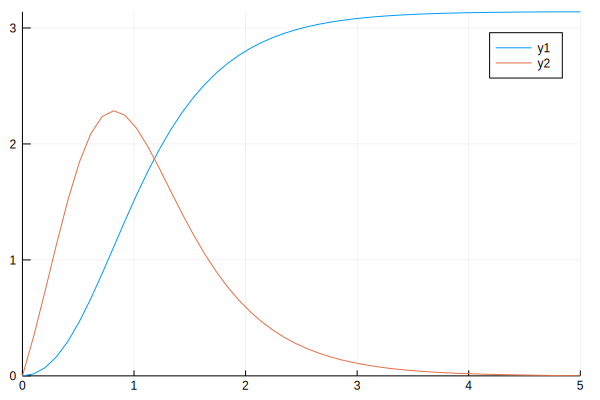

In [38]:
P = plot(linspace(0,tf,size(X,2)),X[1,:])
P = plot!(linspace(0,tf,size(X,2)),X[2,:])

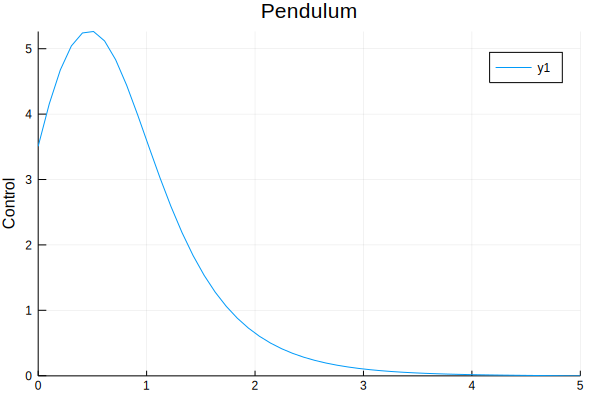

In [39]:
W = plot(linspace(0,tf,size(X,2)),[U[1,:]; U[1,end]],title="Pendulum",ylabel="Control")

In [ ]:
plt = plot()
@gif for i=1:size(X,2)
    x = cos(X[1,i] - pi/2)
    y = sin(X[1,i] - pi/2)
    plt = plot([0,x],[0,y],xlims=(-1.5,1.5),ylims=(-1.5,1.5),color="black",size=(200,200),label="",title="Pendulum")
end 